In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import adjusted_rand_score, adjusted_rand_score
import warnings
warnings.filterwarnings('ignore')


# K-Means

We load the dataset and we drop the columns 'time', 'sample', 'category', 'setting', 'action' and 'active'. Also we convert the  values which belong to the column 'anomaly' into integer values.

In [2]:
df = pd.read_parquet('dataset.parquet')
df = df.drop(['time','sample','category','setting','action','active'], axis=1)
df['anomaly'] = df['anomaly'].astype(int)

In this section we will use UNSUPERVISED METHODS, so we split our dataset into:
* X, which contains all the features except the target column 'anomaly'
* y, which is the target vector or the correct clusterization

In [3]:
X = df.drop('anomaly', axis=1)
y = df['anomaly']

Since we will use methods such as K-Means and PCA, we normalize our dataset by using the function 'MinMaxScaler' from Scikitlearn.

In [7]:
ms = MinMaxScaler()
X_scaled = ms.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = [X.columns])

We create the model and we impose that the final clusterization contains two clusters (0, 1).
Then, we fit the model on the normalize dataframe.

In [8]:
kmeans = KMeans(n_clusters=2, random_state=42, init='k-means++') 
kmeans.fit(X_scaled)

KMeans(n_clusters=2, random_state=42)

We obtain the resulted labels vector from the K-Means method and we compare this vector with the real one y. Here, since we are performing binary classification, we can adopt the following approach

In [9]:
clusters_kmeans = kmeans.predict(X_scaled)
correct_labels = sum(y == clusters_kmeans)

print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))
print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))
report_kmeans = classification_report(y, clusters_kmeans)
print(report_kmeans)

Result: 1244140 out of 2321690 samples were correctly labeled.
Accuracy score: 0.54
              precision    recall  f1-score   support

           0       0.64      0.63      0.64   1488328
           1       0.36      0.36      0.36    833362

    accuracy                           0.54   2321690
   macro avg       0.50      0.50      0.50   2321690
weighted avg       0.54      0.54      0.54   2321690



But, in general, with a number of classes k>2 we cannot use the previous approach. So, one possibility is to calculate the Adjusted Rand Index. The Rand Index is given by:
$$ RI = \frac{NumberOfAgreeingPairs}{NumberOfPairs} $$
It returns a similarity score between 0.0 and 1.0, where 1.0 is the perfect match. However, the Rand Index doesn’t consider the possibility of chance agreements between the two clusters

The Adjusted Rand Index is a correction of the RI:
$$\frac{RI - ExpectedRI}{\max(RI) - ExpectedRI}$$
The adjusted Rand index is thus ensured to have a value close to 0.0 (also negative) for random labeling and exactly 1.0 when the clusterings are identical

In [11]:
ari_kmeans = adjusted_rand_score(y, clusters_kmeans) 
print('Adjusted Rand Score:',ari_kmeans) 

Adjusted Rand Score: -0.0006523355846154675


## Elbow Method
We use the Elbow method in order to understand which number of clusters minimize the  K-Means inertia. Inertia measures how well a dataset was clustered by K-Means. It measures the sum of squared distances between data points ($x_i$) and their assigned cluster centroids ($c_k$).
$$\sum_{k=1}^K \sum_{i=1}^N ||x_i - c_k||^2 $$

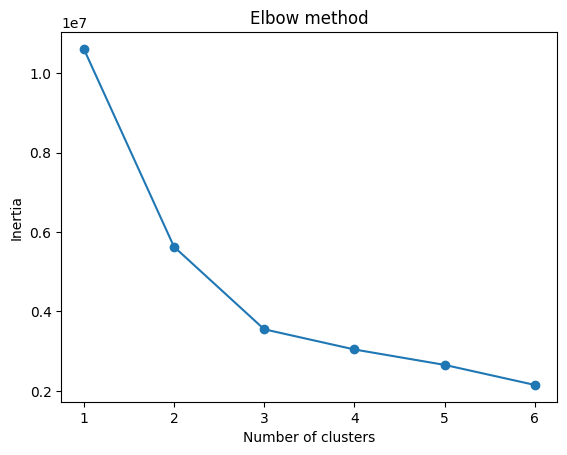

In [7]:
inertias = []

for i in range(1,7):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,7), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

## Visualisation of the result with PCA

We create the dataframe 'df_kmeans' which contains the features of the original dataset, but instead of the true label y, it contains the predicted labels generated with K-Means

In [8]:
df_kmeans = X_scaled
df_kmeans['cluster'] = clusters_kmeans

We create a PCA model and we impose two principal components. We fit our PCA model on the 'df_kmeans' after dropping the column which contains the predicted clusters and we rename the final two columns.

In [9]:
pca_2d = PCA(n_components=2)
PCs_2d = pd.DataFrame(pca_2d.fit_transform(df_kmeans.drop(["cluster"], axis=1)))
PCs_2d.columns = ["PC1_2d", "PC2_2d"]

/var/folders/4n/mn6h9015417130zyvxc9bs200000gn/T/ipykernel_63368/415335932.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  PCs_2d = pd.DataFrame(pca_2d.fit_transform(df_kmeans.drop(["cluster"], axis=1)))


We add the predicted labels in order to visualize the two clusters

In [10]:
PCs_2d['cluster'] = clusters_kmeans

We plot the PCA dataframe in a scatterplot in order to distinguish the clusters.

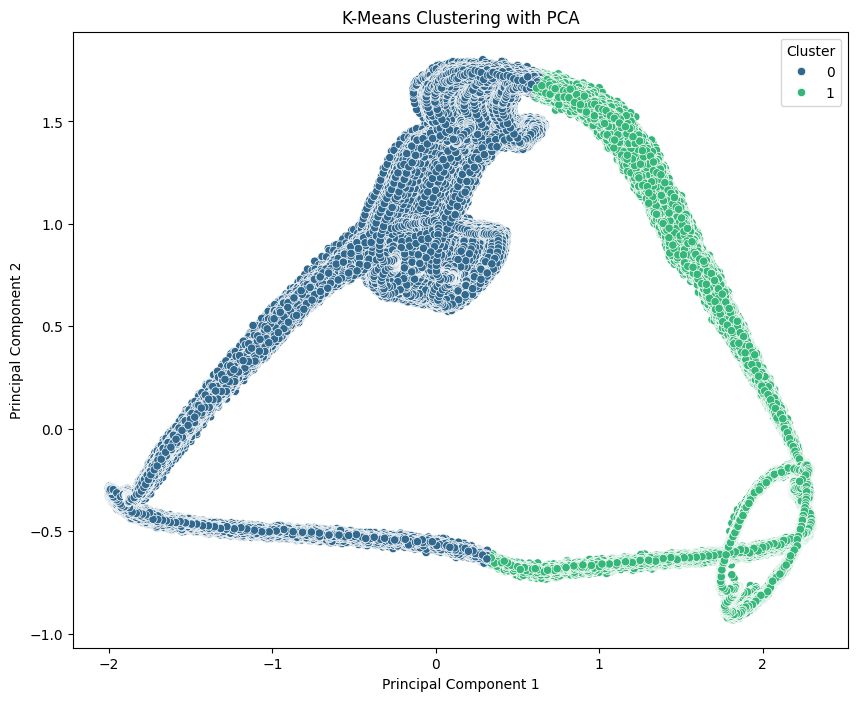

In [11]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=PCs_2d, x='PC1_2d', y='PC2_2d', hue='cluster', palette='viridis')
plt.title('K-Means Clustering with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.show()

# Isolation Forest
Now we apply the same approach, but we use a famous Unsupervised Learning method for anomaly detections, the ISOLATION FOREST. It detects anomalies by using binary trees.

The premise of the Isolation Forest algorithm is that anomalous data points are easier to separate from the rest of the sample. On a practical level: 
* causally dividing a dataset recursively, until each instance has been separated,
* assign an anomaly score $s$ to each data based on the number of divisions that were necessary to isolate it.

$$ s(x,n) = 2^{-\frac{E(h(x))}{c(n)}}$$

where 
* $h(x)$ is the path length, i.e. the number of branches making up the path linking the root to the node where $x$ is located 
* $E(h(x))$ is the average of the path lengths of $x$ from different trees
* $c(n)$ is a normalisation factor given by the average value of $h(x)$ in a tree

We create the Isolation Forest model.

Then we convert the result as integer 0, 1

In [39]:
isf = IsolationForest(random_state=42)
isf.fit(X_scaled)
clusters_isf = isf.predict(X_scaled)
clusters_isf = [1 if pred == -1 else 0 for pred in clusters_isf]

We print the performance by comparing the predicted labels with the true labels

In [40]:
report_isf = classification_report(y, clusters_isf)
print(report_isf)

              precision    recall  f1-score   support

           0       0.64      0.82      0.72   1488328
           1       0.36      0.18      0.24    833362

    accuracy                           0.59   2321690
   macro avg       0.50      0.50      0.48   2321690
weighted avg       0.54      0.59      0.55   2321690



In [41]:
ari_isf = adjusted_rand_score(y, clusters_isf) 
print('Adjusted Rand Score:',ari_isf) 

Adjusted Rand Score: 0.0006795567613214627


## Visualisation of the results with PCA
The process is the same as the previous one with K-Means, so we don't add any explanation

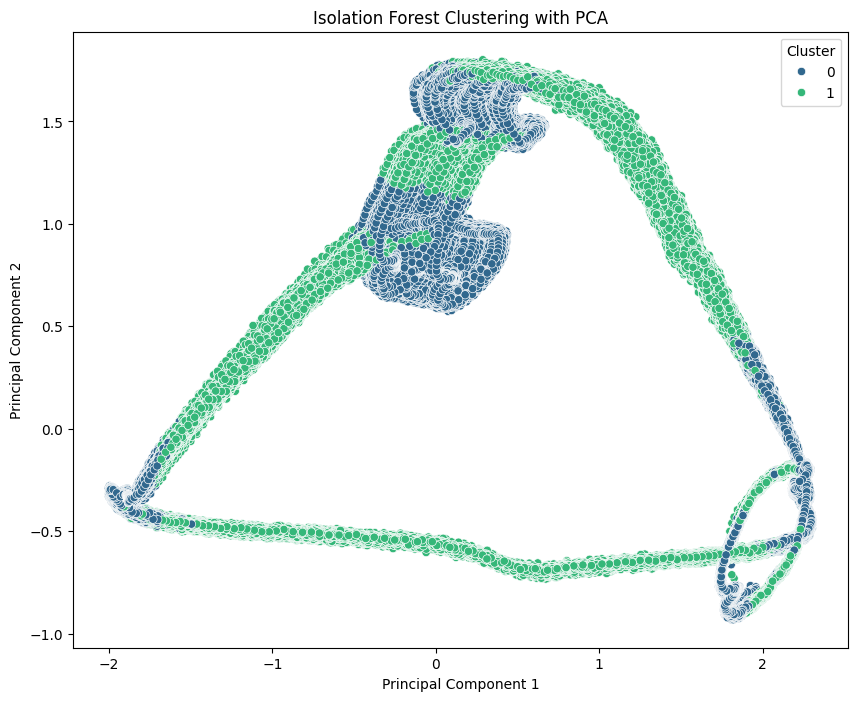

In [42]:
df_isf = X_scaled
df_isf['cluster'] = clusters_isf
pca_2d = PCA(n_components=2)
PCisf_2d = pd.DataFrame(pca_2d.fit_transform(df_isf.drop(["cluster"], axis=1)))
PCisf_2d.columns = ["PC1_2d", "PC2_2d"]
PCisf_2d['cluster'] = clusters_isf
plt.figure(figsize=(10, 8))
sns.scatterplot(data=PCisf_2d, x='PC1_2d', y='PC2_2d', hue='cluster', palette='viridis')
plt.title('Isolation Forest Clustering with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.show()

# Visualisation of the original dataset with PCA

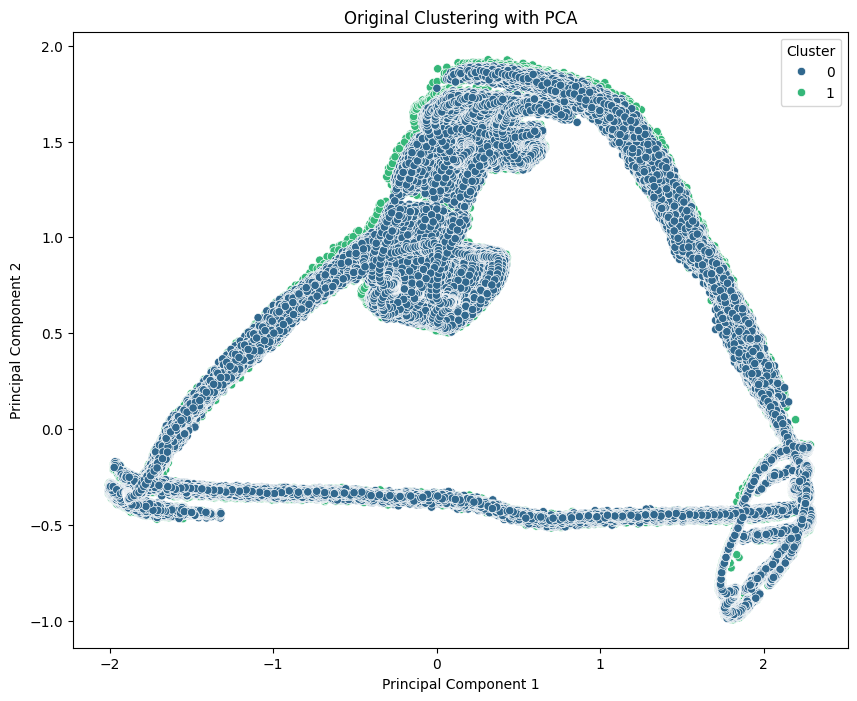

In [43]:
pca_2d = PCA(n_components=2)
PCreal_2d = pd.DataFrame(pca_2d.fit_transform(X_scaled))
PCreal_2d.columns = ["PC1_2d", "PC2_2d"]
PCreal_2d['cluster'] = y
plt.figure(figsize=(10, 8))
sns.scatterplot(data=PCreal_2d, x='PC1_2d', y='PC2_2d', hue='cluster', palette='viridis')
plt.title('Original Clustering with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.show()

# Comparison
We can now show the principal differences of performance between Isolation Forest and K-Means

We recall the classification_report as a dictionary

In [72]:
report_method1 = classification_report(y, clusters_kmeans, output_dict=True)
report_method2 = classification_report(y, clusters_isf, output_dict=True)

We select the metrics ('precision', 'recall' and 'f1-score') and the classes (0,1)

In [74]:
metrics = ['precision', 'recall', 'f1-score']
classes = list(report_method1.keys())[:-3]

We insert the values in a new dataframe

In [75]:
data = []
for cls in classes:
    for metric in metrics:
        data.append([cls, metric, report_method1[cls][metric], 'K-Means'])
        data.append([cls, metric, report_method2[cls][metric], 'IsF'])
df = pd.DataFrame(data, columns=['Class', 'Metric', 'Score', 'Method'])

We plot the results

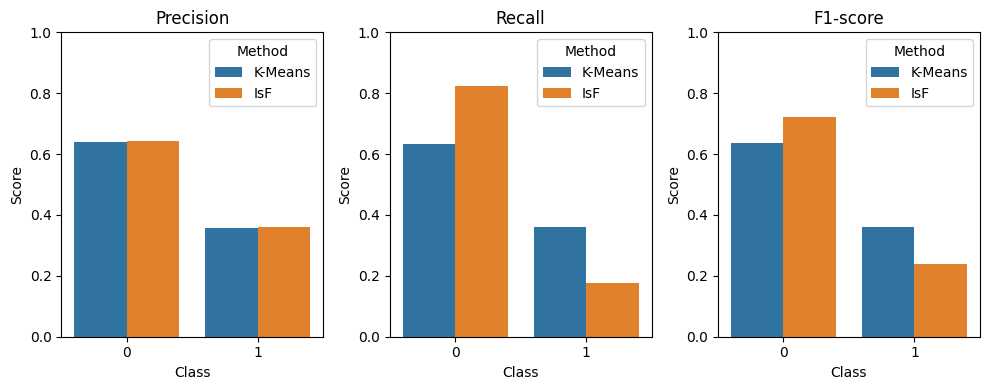

In [77]:
fig, axes = plt.subplots(1, 3, figsize=(10,4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.barplot(ax=ax, x='Class', y='Score', hue='Method', data=df[df['Metric'] == metric], ci=None, capsize=.1)
    ax.set_title(metric.capitalize())
    ax.set_ylim(0, 1)
    ax.set_ylabel('Score')
    ax.set_xlabel('Class')

plt.tight_layout()
plt.show()